# 0. Setup

Reference: 
https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

2023-01-05 19:45:44.652875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Dataset

In [2]:
csv_path = 'australia_data/'

In [6]:
original_df = pd.read_csv(os.path.join(csv_path,r'weatherAUS.csv'))

In [7]:
original_df.shape

(145460, 23)

In [8]:
original_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [15]:
original_df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [17]:
dropped_df = original_df.iloc[:,[0,1,2,3,4,11,12,13,14,15,16,17,18,19,20]]

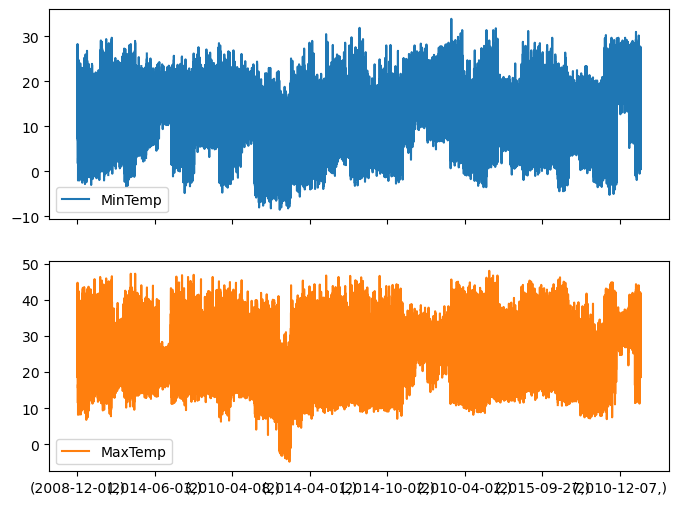

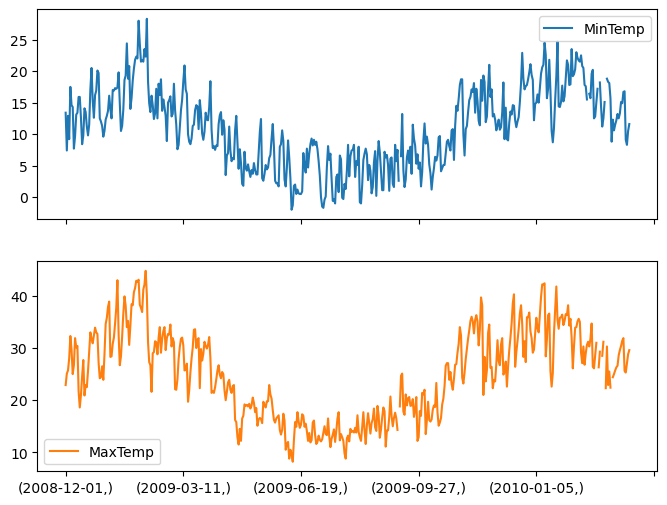

In [24]:
plot_cols = ["MinTemp", "MaxTemp"]
plot_features = dropped_df[plot_cols]
plot_features.index = dropped_df[['Date']]
_ = plot_features.plot(subplots=True)

plot_features = dropped_df[plot_cols][:480]
plot_features.index = dropped_df[['Date']][:480]
_ = plot_features.plot(subplots=True)

## 1-1. Inspect and cleanup

In [25]:
dropped_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0
Pressure9am,130395.0,1017.649940,7.106530,980.5,1012.9,1017.6,1022.4,1041.0
Pressure3pm,130432.0,1015.255889,7.037414,977.1,1010.4,1015.2,1020.0,1039.6
Cloud9am,89572.0,4.447461,2.887159,0.0,1.0,5.0,7.0,9.0


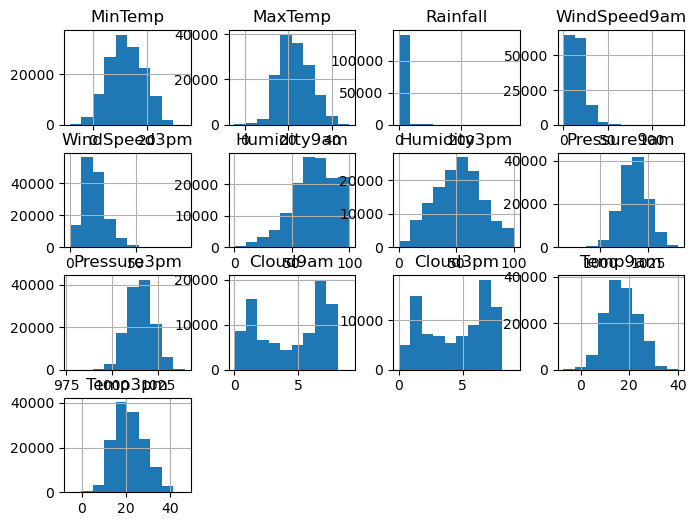

In [26]:
dropped_df.hist()
plt.show()

## 1-2. Feature engineering

In [27]:
dropped_df.dtypes

Date             object
Location         object
MinTemp         float64
MaxTemp         float64
Rainfall        float64
WindSpeed9am    float64
WindSpeed3pm    float64
Humidity9am     float64
Humidity3pm     float64
Pressure9am     float64
Pressure3pm     float64
Cloud9am        float64
Cloud3pm        float64
Temp9am         float64
Temp3pm         float64
dtype: object

In [28]:
dropped_df2 = dropped_df.drop(columns=['Date'])

In [32]:
dropped_df2.groupby(by='Location').describe()

MinTemp                                                  \
                   count       mean       std   min   25%    50%     75%   
Location                                                                   
Adelaide          3191.0  12.579505  4.986596   0.7   9.1  12.10  15.500   
Albany            2977.0  12.948438  3.545188   1.8  10.3  12.90  15.800   
Albury            3029.0   9.530604  6.069485  -2.8   4.7   9.10  14.300   
AliceSprings      3039.0  13.142284  7.748471  -5.2   6.8  13.70  19.750   
BadgerysCreek     2973.0  11.131719  5.633795  -3.0   6.6  11.40  15.900   
Ballarat          3039.0   7.367950  4.719704  -5.6   4.2   7.00  10.400   
Bendigo           3038.0   8.593713  5.697443  -4.0   4.3   8.20  12.575   
Brisbane          3184.0  16.423807  4.616583   2.6  12.8  16.80  20.300   
Cairns            3039.0  21.220467  3.176509   9.2  19.4  21.90  23.700   
Canberra          3430.0   6.821866  6.242953  -8.0   1.8   7.00  11.900   
Cobar             3003.0  13.149451  6.725802  -2.0   7.4  13.00  18.500   
CoffsHarbour      2994.0  14.437108  5.142664   0.6  10.7  15.15  18.500   
Dartmoor          2940.0   8.620034  4.170732  -2.7   5.7   8.50  11.400   
Darwin            3192.0  23.209305  2.968970  12.5  21.6  23.90  25.300   
GoldCoast         3037.0  17.363286  4.115452   4.9  14.2  17.70  20.900   
Hobart            3193.0   9.078578  3.897084  -0.4   6.1   9.00  11.900   
Katherine         1529.0  20.553564  5.100651   5.2  17.0  22.40  24.500   
Launceston        3034.0   7.836190  4.943563  -3.5   4.1   7.90  11.500   
Melbourne         2713.0  11.779174  4.208313   1.4   8.7  11.40  14.600   
MelbourneAirport  3009.0   9.973945  4.481929  -1.0   6.7   9.50  13.000   
Mildura           3009.0  10.731572  6.057556  -3.2   6.2  10.10  15.000   
Moree             3007.0  12.905853  6.811774  -3.3   7.2  13.50  18.700   
MountGambier      3038.0   8.825477  3.999872  -2.1   6.1   8.60  11.400   
MountGinini       2949.0   3.577280  5.374270  -8.5  -0.7   3.10   7.600   
Newcastle         2693.0  13.760007  5.003698   2.2   9.7  13.80  18.000   
Nhil              1573.0   8.999809  5.107077  -2.3   5.4   8.40  12.200   
NorahHead         2974.0  15.355481  4.149259   4.6  12.0  15.60  19.000   
NorfolkIsland     3008.0  16.871875  2.761056   9.4  14.7  16.70  19.100   
Nuriootpa         2998.0   9.363242  5.151055  -3.5   5.8   9.00  12.600   
PearceRAAF        2987.0  12.303850  5.243401  -1.9   8.7  12.20  15.900   
Penrith           3011.0  12.577449  5.526524  -1.1   8.2  12.90  17.200   
Perth             3193.0  12.922706  5.087817  -0.6   9.2  13.10  16.600   
PerthAirport      3009.0  12.580359  5.093569  -1.0   8.9  12.50  16.300   
Portland          3000.0   9.586867  3.586086  -1.5   7.1   9.50  12.100   
Richmond          2989.0  11.364202  6.103940  -4.8   6.5  11.80  16.500   
Sale              3008.0   8.567420  4.907297  -3.9   4.9   8.30  12.200   
SalmonGums        2960.0   9.313007  5.483728  -4.4   5.3   9.20  13.600   
Sydney            3340.0  14.866826  4.551618   4.3  11.0  14.90  18.725   
SydneyAirport     3008.0  14.901729  4.640967   3.2  11.0  15.10  18.900   
Townsville        3038.0  20.417874  4.562407   6.4  17.4  21.50  24.000   
Tuggeranong       3038.0   7.242133  6.348866  -8.2   2.1   7.40  12.400   
Uluru             1543.0  14.466688  7.446991  -1.9   8.2  14.90  21.000   
WaggaWagga        3009.0   9.617182  6.551019  -4.7   4.3   9.20  14.800   
Walpole           2971.0  11.806631  3.226613   2.6   9.4  11.80  14.000   
Watsonia          3002.0  10.131879  4.542496  -2.1   7.0   9.80  13.300   
Williamtown       3007.0  12.780180  5.104967  -1.8   8.8  12.80  17.000   
Witchcliffe       3000.0  10.775067  3.925484  -0.7   7.9  10.90  13.600   
Wollongong        3025.0  14.939471  3.820357   5.4  11.8  15.00  18.000   
Woomera           3005.0  13.363727  6.197374   0.7   8.2  13.10  17.800   

                       MaxTemp             ... Temp9am       Tem

In [40]:
sydney_df = dropped_df2[dropped_df2['Location'] == 'Sydney'].drop(columns = 'Location')

In [42]:
sydney_df.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
30176,19.5,22.4,15.6,17.0,20.0,92.0,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9
30177,19.5,25.6,6.0,9.0,13.0,83.0,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8
30178,21.6,24.5,6.6,17.0,2.0,88.0,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0
30179,20.2,22.8,18.8,22.0,20.0,83.0,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9
30180,19.7,25.7,77.4,11.0,6.0,88.0,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5


In [93]:
sydney_df.isnull().sum()

MinTemp           4
MaxTemp           2
Rainfall          7
WindSpeed9am     26
WindSpeed3pm     25
Humidity9am      15
Humidity3pm      13
Pressure9am      21
Pressure3pm      19
Cloud9am        568
Cloud3pm        563
Temp9am           5
Temp3pm           4
dtype: int64

In [95]:
sydney_df = sydney_df.interpolate()

## 1-3. Split the data

In [96]:
print(f'train: {sydney_df.shape}')

train: (3344, 13)


In [97]:
column_indices = {name: i for i, name in enumerate(sydney_df.columns)}

n = len(sydney_df)
train_df = sydney_df[0:int(n*0.7)]
val_df = sydney_df[int(n*0.7):int(n*0.9)]
test_df = sydney_df[int(n*0.9):]

num_features = sydney_df.shape[1]

In [98]:
print(f'train: {train_df.shape}')
print(f'train: {val_df.shape}')
print(f'train: {test_df.shape}')

train: (2340, 13)
train: (669, 13)
train: (335, 13)


## 1-4. Normalize the data

In [99]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

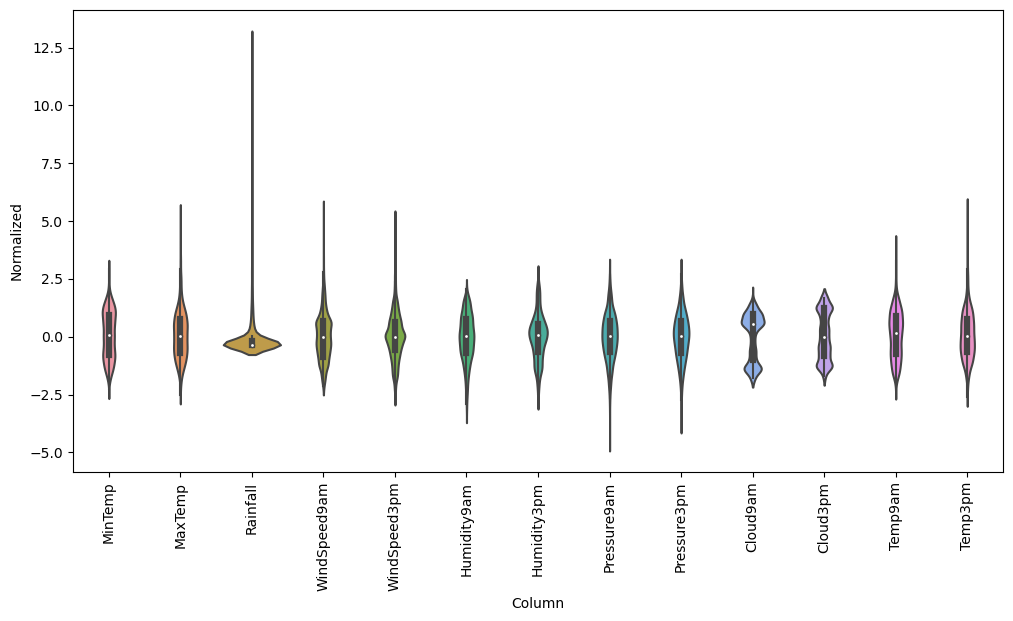

In [100]:
df_std = (sydney_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(sydney_df.keys(), rotation=90)

# 2. Data Windowing

## 2-1. Indexes and offsets

In [101]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [102]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['MaxTemp'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['MaxTemp']

In [103]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['MaxTemp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['MaxTemp']

## 2-2. Split

In [104]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [105]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 13)
Inputs shape: (3, 6, 13)
Labels shape: (3, 1, 1)


## 2-3. Plot

In [106]:
w2.example = example_inputs, example_labels

In [107]:
def plot(self, model=None, plot_col='MaxTemp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

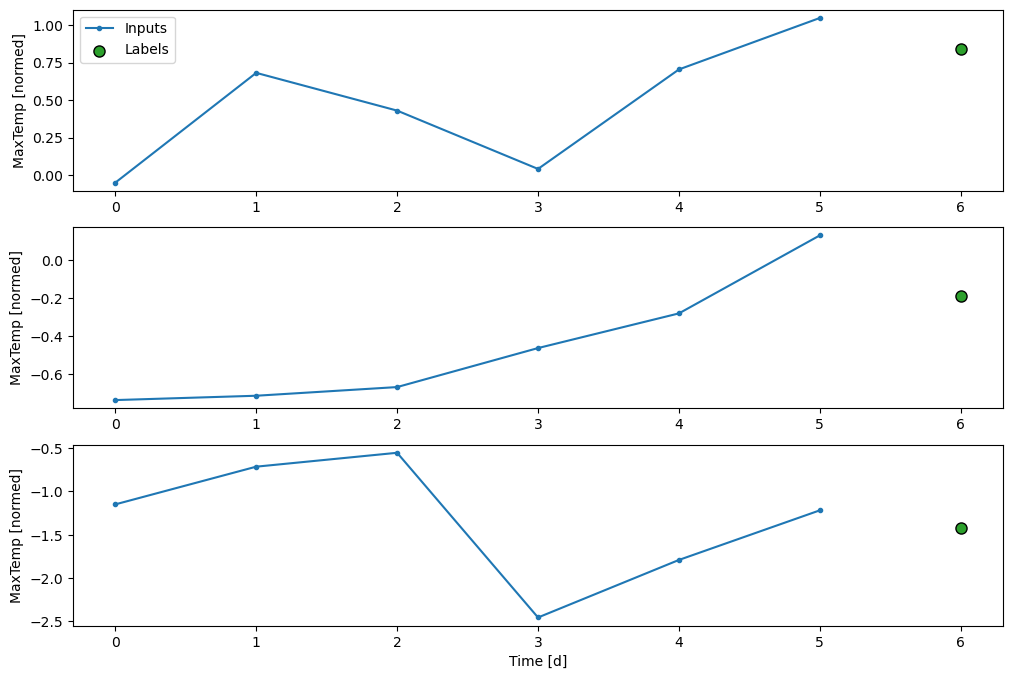

In [108]:
w2.plot()

## 2-4. Create tf.data.Datasets

In [109]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [110]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [111]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 13), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [112]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 13)
Labels shape (batch, time, features): (32, 1, 1)


# 3. Single step models

In [113]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['MaxTemp'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['MaxTemp']

In [114]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 13)
Labels shape (batch, time, features): (32, 1, 1)


## 3-1. Baseline

In [115]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [116]:
baseline = Baseline(label_index=column_indices['MaxTemp'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 3ms/step - loss: 0.7033 - mean_absolute_error: 0.5810


### Wide window

In [117]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['MaxTemp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['MaxTemp']

In [118]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


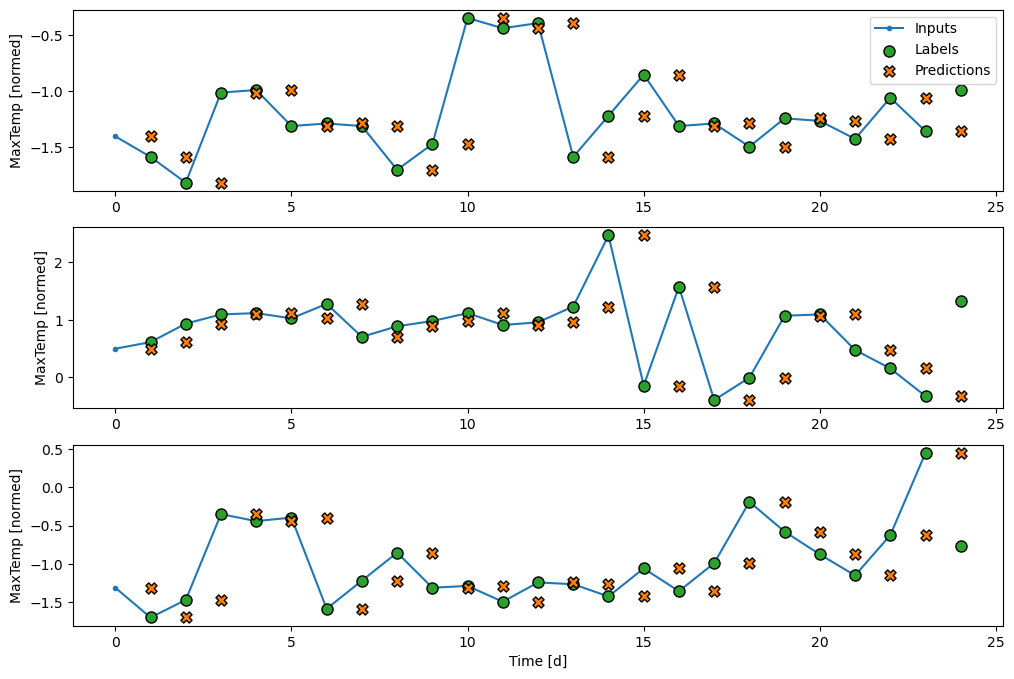

In [119]:
wide_window.plot(baseline)

## 3-2. Linear Model

- Insert linear transformation between the input and output.

In [120]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [121]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


- Package the training procedure into a fuction

In [122]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [123]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)


Epoch 1/20
74/74 [==============================] - 1s 9ms/step - loss: 1.3676 - mean_absolute_error: 0.8800 - val_loss: 1.4253 - val_mean_absolute_error: 0.8914
Epoch 2/20
74/74 [==============================] - 1s 10ms/step - loss: 1.1586 - mean_absolute_error: 0.8103 - val_loss: 1.2267 - val_mean_absolute_error: 0.8211
Epoch 3/20
74/74 [==============================] - 1s 7ms/step - loss: 0.9940 - mean_absolute_error: 0.7463 - val_loss: 1.0683 - val_mean_absolute_error: 0.7592
Epoch 4/20
74/74 [==============================] - 0s 6ms/step - loss: 0.8610 - mean_absolute_error: 0.6916 - val_loss: 0.9356 - val_mean_absolute_error: 0.7070
Epoch 5/20
74/74 [==============================] - 1s 6ms/step - loss: 0.7599 - mean_absolute_error: 0.6457 - val_loss: 0.8355 - val_mean_absolute_error: 0.6664
Epoch 6/20
74/74 [==============================] - 1s 6ms/step - loss: 0.6803 - mean_absolute_error: 0.6093 - val_loss: 0.7544 - val_mean_absolute_error: 0.6329
Epoch 7/20
74/74 [=========

In [124]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [125]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


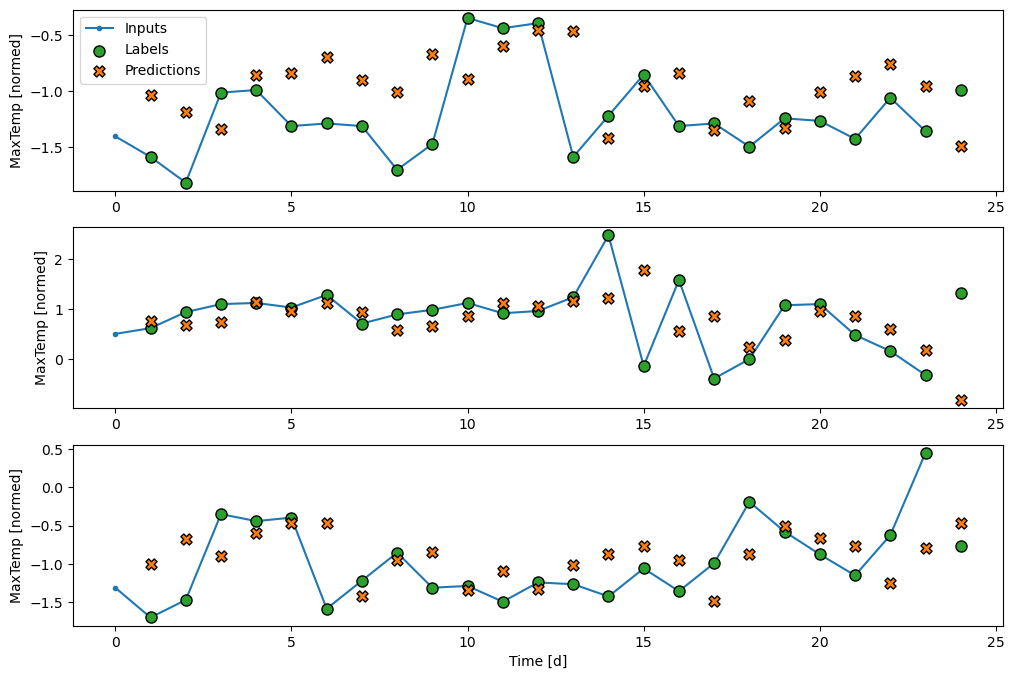

In [126]:
wide_window.plot(linear)

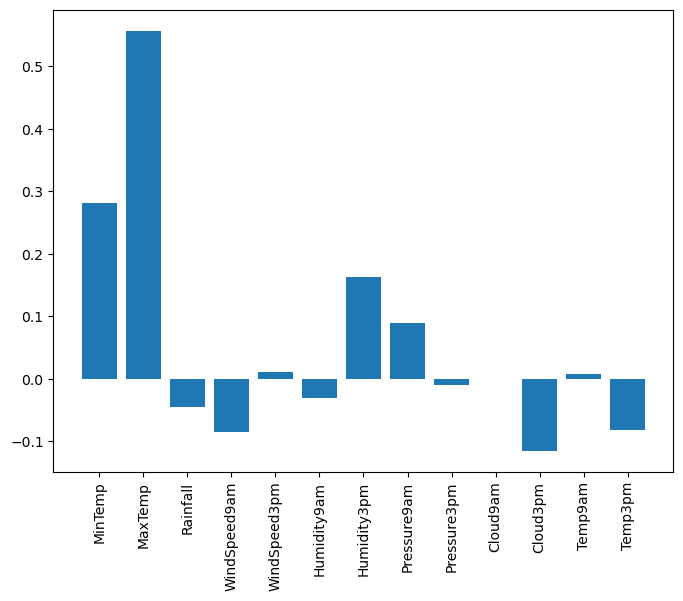

In [127]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## 3-3. Dense

In [128]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
74/74 [==============================] - 2s 11ms/step - loss: 0.5220 - mean_absolute_error: 0.5346 - val_loss: 0.4669 - val_mean_absolute_error: 0.4971
Epoch 2/20
74/74 [==============================] - 1s 8ms/step - loss: 0.4087 - mean_absolute_error: 0.4670 - val_loss: 0.4535 - val_mean_absolute_error: 0.4952
Epoch 3/20
74/74 [==============================] - 1s 7ms/step - loss: 0.3951 - mean_absolute_error: 0.4580 - val_loss: 0.4500 - val_mean_absolute_error: 0.4932
Epoch 4/20
74/74 [==============================] - 1s 8ms/step - loss: 0.3824 - mean_absolute_error: 0.4507 - val_loss: 0.4430 - val_mean_absolute_error: 0.4838
Epoch 5/20
74/74 [==============================] - 1s 7ms/step - loss: 0.3718 - mean_absolute_error: 0.4417 - val_loss: 0.4424 - val_mean_absolute_error: 0.4840
Epoch 6/20
74/74 [==============================] - 1s 7ms/step - loss: 0.3636 - mean_absolute_error: 0.4358 - val_loss: 0.4490 - val_mean_absolute_error: 0.4928
Epoch 7/20
21/21 [=========

## 3-4. Multi-step dense

In [155]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['MaxTemp'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['MaxTemp']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

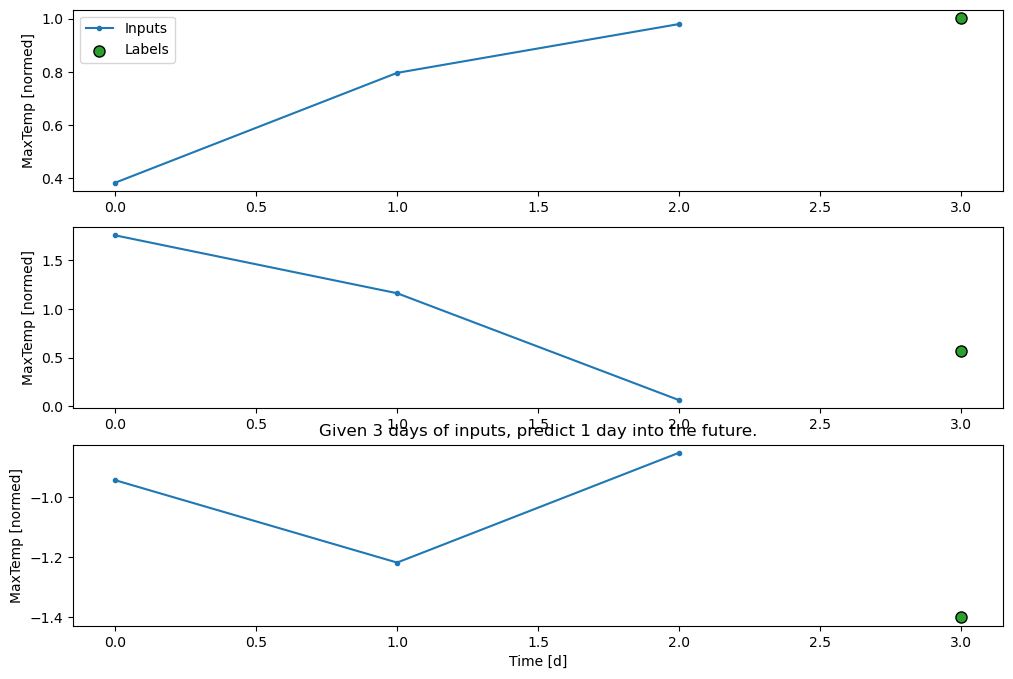

In [156]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [157]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [158]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [159]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
74/74 [==============================] - 1s 9ms/step - loss: 0.5839 - mean_absolute_error: 0.5680 - val_loss: 0.5807 - val_mean_absolute_error: 0.5606
Epoch 2/20
74/74 [==============================] - 0s 6ms/step - loss: 0.4518 - mean_absolute_error: 0.4919 - val_loss: 0.5270 - val_mean_absolute_error: 0.5286
Epoch 3/20
74/74 [==============================] - 1s 9ms/step - loss: 0.4162 - mean_absolute_error: 0.4725 - val_loss: 0.5123 - val_mean_absolute_error: 0.5236
Epoch 4/20
74/74 [==============================] - 0s 5ms/step - loss: 0.3987 - mean_absolute_error: 0.4647 - val_loss: 0.4946 - val_mean_absolute_error: 0.5123
Epoch 5/20
74/74 [==============================] - 0s 6ms/step - loss: 0.3800 - mean_absolute_error: 0.4513 - val_loss: 0.5000 - val_mean_absolute_error: 0.5147
Epoch 6/20
74/74 [==============================] - 0s 5ms/step - loss: 0.3665 - mean_absolute_error: 0.4439 - val_loss: 0.4867 - val_mean_absolute_error: 0.5067
Epoch 7/20
74/74 [==========

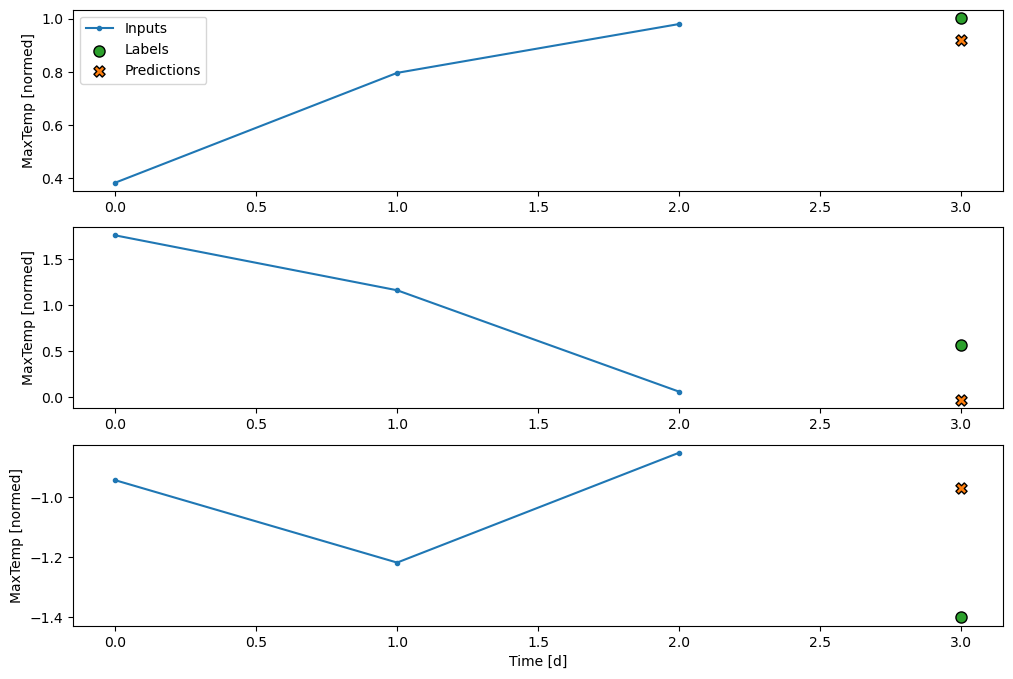

In [160]:
conv_window.plot(multi_step_dense)

## 3-5. Convolution neural network

In [161]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [162]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [163]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

21/21 [==============================] - 0s 8ms/step - loss: 0.4643 - mean_absolute_error: 0.5005


In [164]:
conv_model.metrics_names

['loss', 'mean_absolute_error']

In [165]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [166]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['MaxTemp'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['MaxTemp']

In [167]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


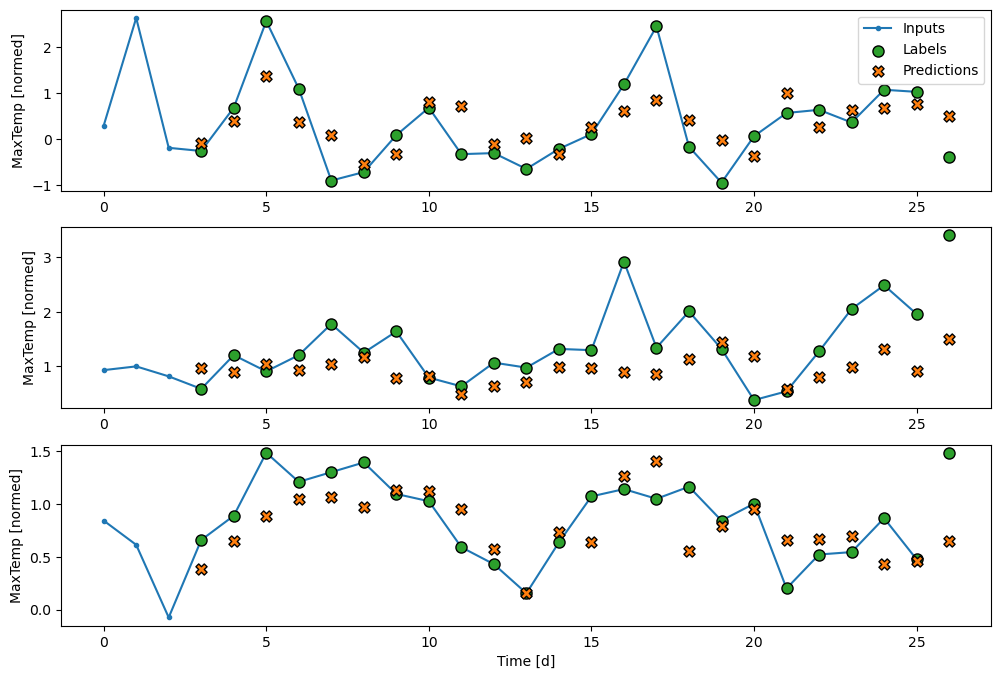

In [168]:
wide_conv_window.plot(conv_model)

## 3-6. Recurrent neural network

Yet to be done

## 3-7. Performance

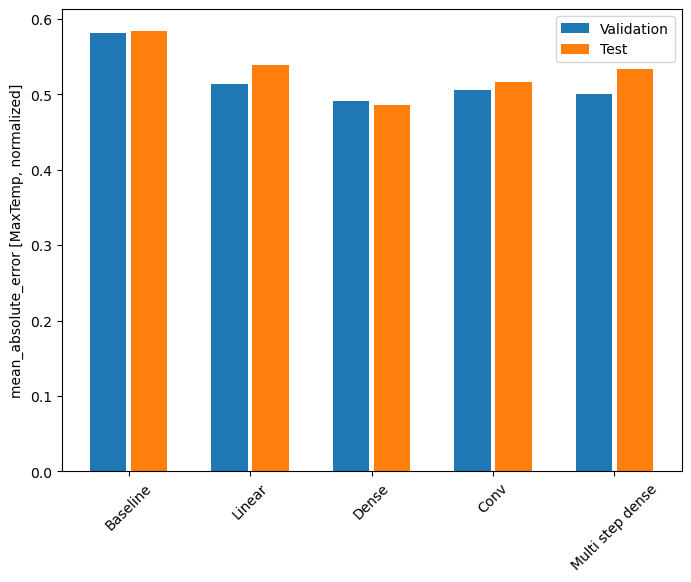

In [169]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[1] for v in val_performance.values()]
test_mae = [v[1] for v in performance.values()]

plt.ylabel('mean_absolute_error [MaxTemp, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## 3-8. Multi-output models

- Output:

In [170]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 13)
Labels shape (batch, time, features): (32, 24, 13)


### Baseline

In [173]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [174]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

21/21 [==============================] - 0s 5ms/step - loss: 1.0371 - mean_absolute_error: 0.6912


### Dense

In [175]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [176]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 6ms/step - loss: 0.6365 - mean_absolute_error: 0.5677


### Performance

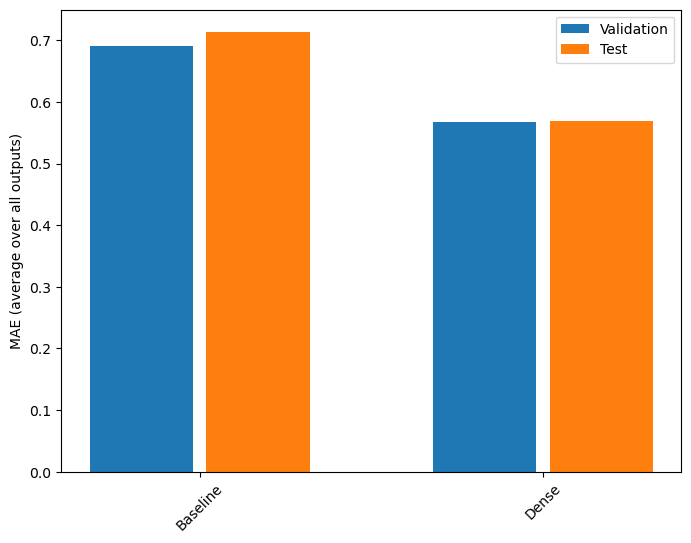

In [177]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[1] for v in val_performance.values()]
test_mae = [v[1] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# 4. Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

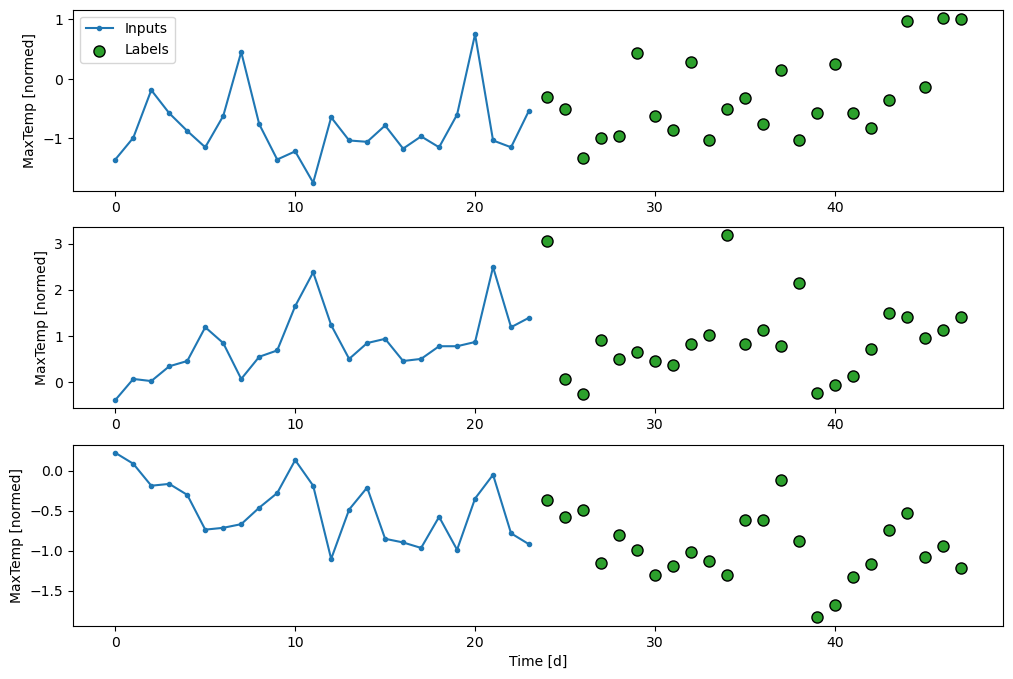

In [179]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## 4-1. Baselines

20/20 [==============================] - 0s 5ms/step - loss: 1.6417 - mean_absolute_error: 0.9129


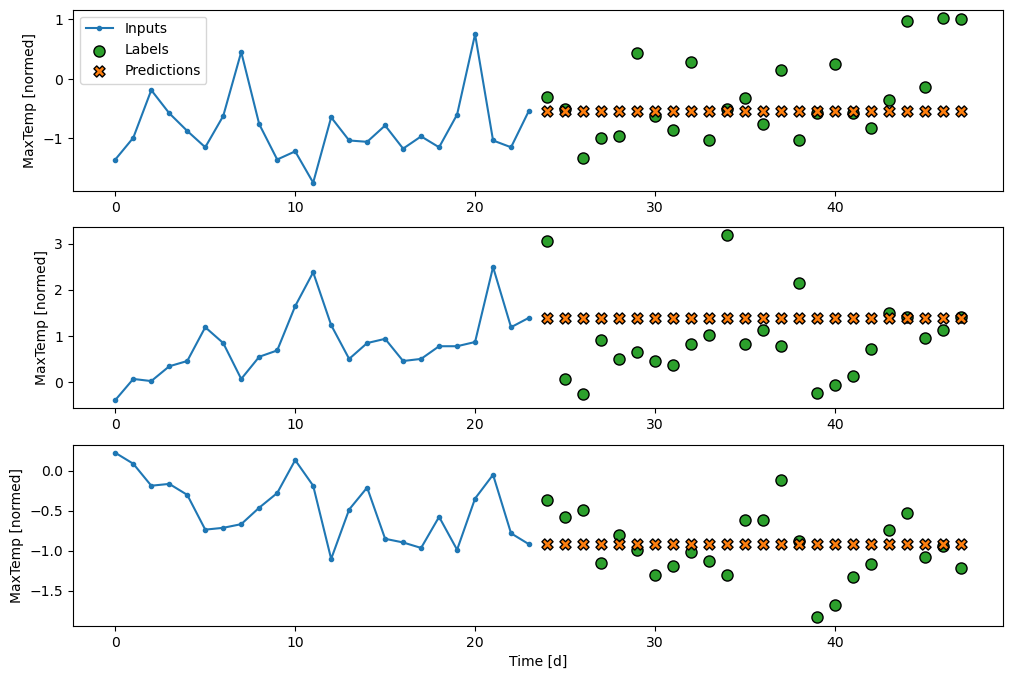

In [180]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

20/20 [==============================] - 1s 4ms/step - loss: 1.7042 - mean_absolute_error: 0.9386


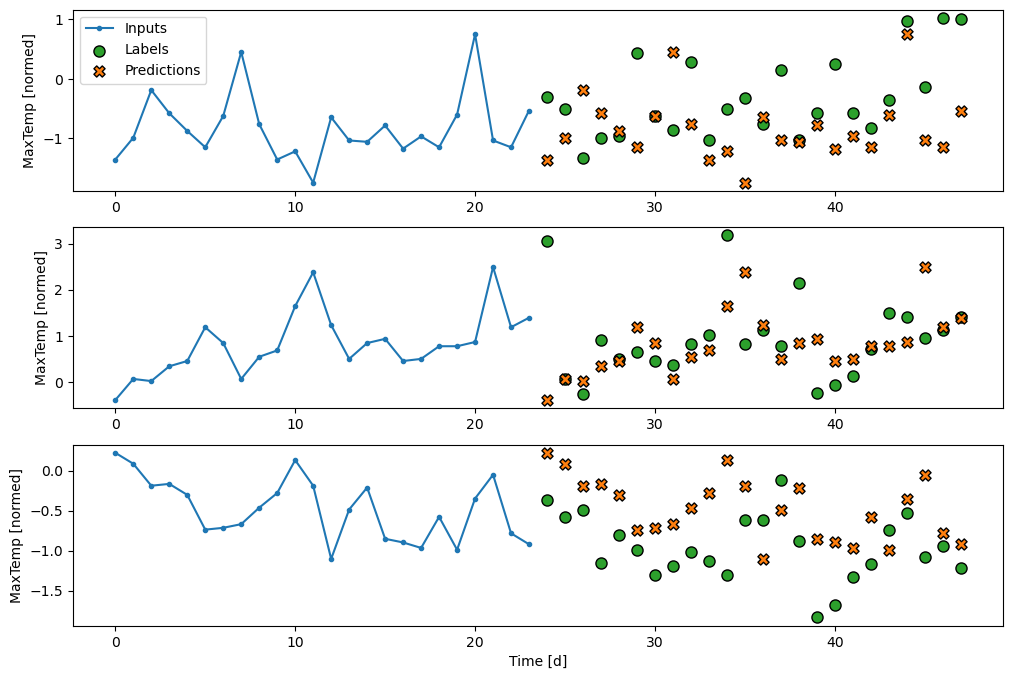

In [181]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## 4-2. Single-shot models

### Linear

20/20 [==============================] - 0s 5ms/step - loss: 0.9066 - mean_absolute_error: 0.7154


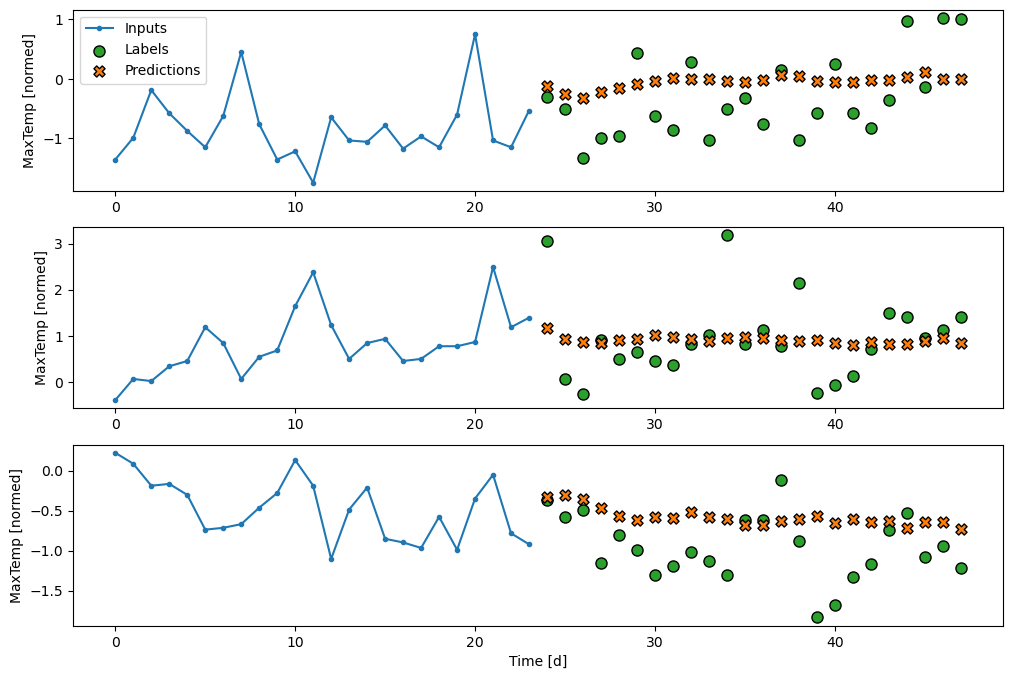

In [182]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

20/20 [==============================] - 0s 5ms/step - loss: 0.9021 - mean_absolute_error: 0.7115


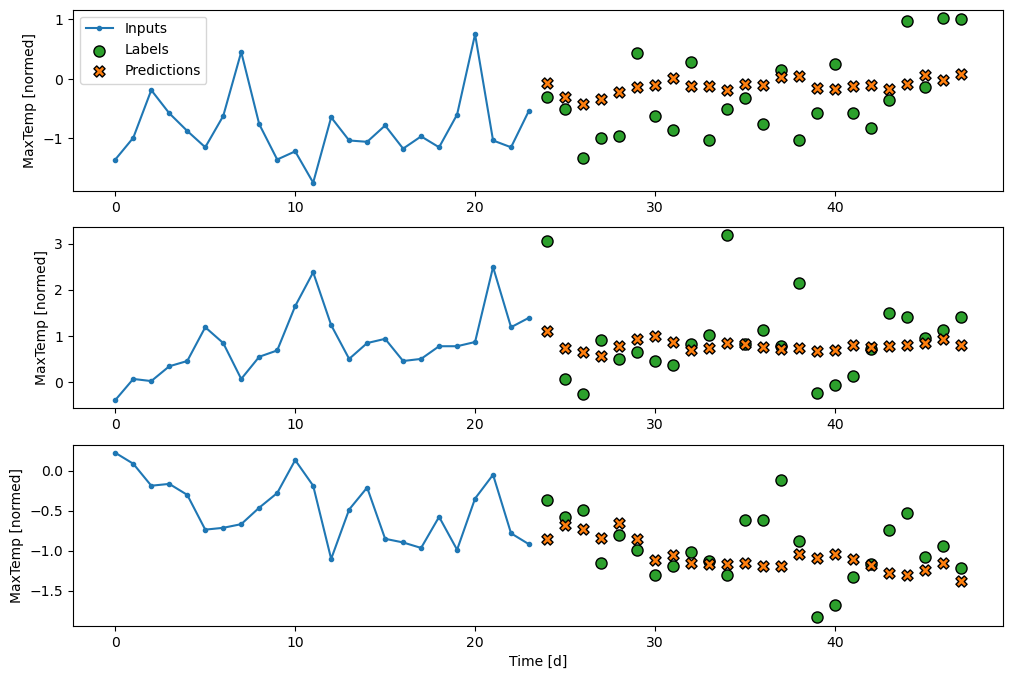

In [183]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

20/20 [==============================] - 0s 8ms/step - loss: 0.8984 - mean_absolute_error: 0.7108


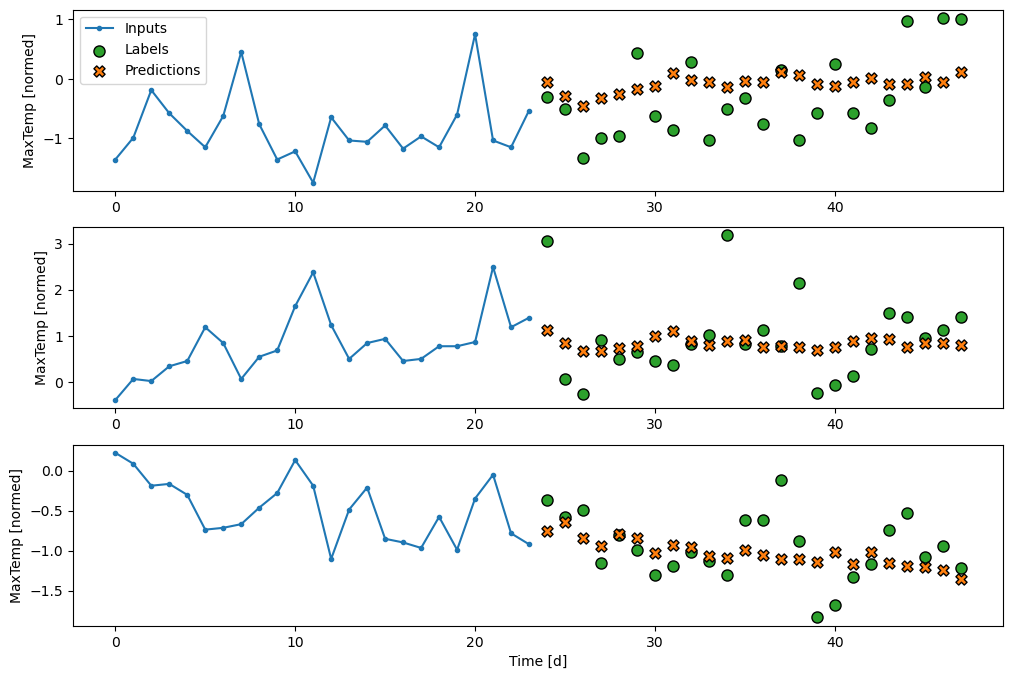

In [184]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### RNN

Yet to be done

## 4-3. Advanced: Autoregressive model

Yet To be done

## 4-4. Peroformance

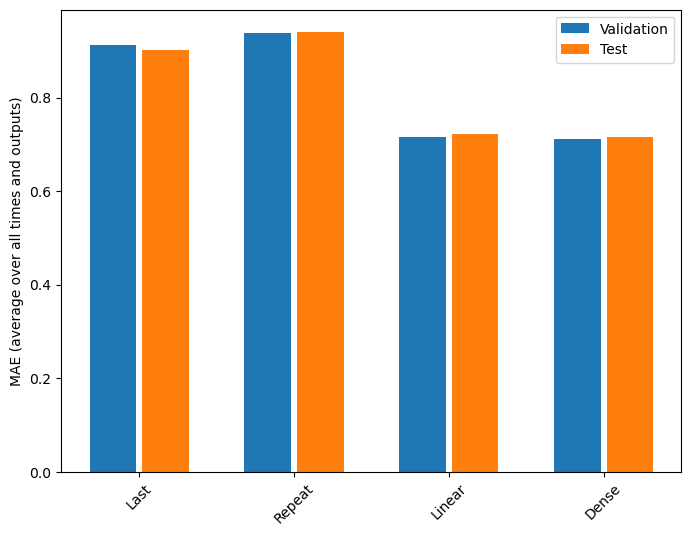

In [185]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[1] for v in multi_val_performance.values()]
test_mae = [v[1] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()